# S4 — pandas : **jointures, reshaping & séries temporelles** (M1 ECAP)

**Objectifs (4h)** : merges, reshaping, time series (resample, rolling, YoY) + graphiques simples.

**Datasets** (`;`) : `ventes_mensuelles.csv`, `inflation_mensuelle.csv`, `chomage_trimestriel.csv`.

## 0) Imports & réglages

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10); pd.set_option("display.width", 140)
DATA_SALES, DATA_INFL, DATA_UNEMP = "data/ventes_mensuelles.csv", "data/inflation_mensuelle.csv", "data/chomage_trimestriel.csv"
OUT_DIR = "outputs"; os.makedirs(OUT_DIR, exist_ok=True)
DATA_SALES, DATA_INFL, DATA_UNEMP

('data/ventes_mensuelles.csv',
 'data/inflation_mensuelle.csv',
 'data/chomage_trimestriel.csv')

## 1) Chargement & parsing

In [2]:
ventes = pd.read_csv(DATA_SALES, sep=';', parse_dates=['date'], encoding='utf-8')
infl = pd.read_csv(DATA_INFL, sep=';', parse_dates=['date'], encoding='utf-8')
chom = pd.read_csv(DATA_UNEMP, sep=';', parse_dates=['periode'], encoding='utf-8')

def to_num(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.replace('\u202f',' ', regex=False)
            .str.replace(' ','', regex=False).str.replace(',','.', regex=False)
            .replace({'':np.nan,'-':np.nan,'—':np.nan,'?':np.nan})).astype(float)

ventes['ventes_k€'] = to_num(ventes['ventes_k€'])
infl['taux_inflation'] = to_num(infl['taux_inflation'])
chom['chomage_pourcent'] = to_num(chom['chomage_pourcent'])

ventes.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/ventes_mensuelles.csv'

## 2) Jointures

In [14]:
vi = pd.merge(ventes, infl, how='left', on=['region','date'])
vi.head()

,region,date,ventes_k€,taux_inflation
0,Île-de-France,2019-01-01,726.3,2.6
1,Île-de-France,2019-02-01,811.1,2.0
2,Île-de-France,2019-03-01,786.5,2.7
3,Île-de-France,2019-04-01,699.1,1.9
4,Île-de-France,2019-05-01,813.4,1.5


In [15]:
# Chômage trimestriel -> mensuel par forward-fill par région
# forward-fill : on remplit les valeurs manquantes avec la dernière valeur connue
# resample('MS') : on resample les données pour avoir une fréquence mensuelle (MS = Month Start)
# groupby(level=0) : on groupe par région (level=0 car on a mis 'region' en index)
# droplevel(0) : on enlève le niveau 'region' de l'index pour resampler
# rename_axis(['region','date']) : on renomme les axes de l'index
# reset_index() : on remet 'region' et 'date' en colonnes
chom_m = (chom.set_index(['region','periode']).groupby(level=0)
          .apply(lambda g: g.droplevel(0).resample('MS').ffill())
          .rename_axis(['region','date']).reset_index())

full = pd.merge(vi, chom_m, how='left', on=['region','date'])
full.head()

,region,date,ventes_k€,taux_inflation,chomage_pourcent
0,Île-de-France,2019-01-01,726.3,2.6,7.1
1,Île-de-France,2019-02-01,811.1,2.0,7.1
2,Île-de-France,2019-03-01,786.5,2.7,7.1
3,Île-de-France,2019-04-01,699.1,1.9,6.4
4,Île-de-France,2019-05-01,813.4,1.5,6.4


## 3) Reshaping (pivot/melt)

In [16]:
pivot_ventes = full.pivot_table(index='date', columns='region', values='ventes_k€')
pivot_ventes.head()

region,Auvergne-Rhône-Alpes,Bretagne,Hauts-de-France,Occitanie,Île-de-France
date,,,,,
2019-01-01,1222.8,922.4,1107.5,1199.3,726.3
2019-02-01,1226.2,866.3,1102.2,1295.2,811.1
2019-03-01,1254.9,848.8,1050.6,1237.7,786.5
2019-04-01,1280.2,918.1,1131.9,1276.1,699.1
2019-05-01,1224.1,940.7,1087.1,1112.0,813.4


In [17]:
ventes_long = pivot_ventes.reset_index().melt(id_vars='date', var_name='region', value_name='ventes_k€')
ventes_long.head()

,date,region,ventes_k€
0,2019-01-01,Auvergne-Rhône-Alpes,1222.8
1,2019-02-01,Auvergne-Rhône-Alpes,1226.2
2,2019-03-01,Auvergne-Rhône-Alpes,1254.9
3,2019-04-01,Auvergne-Rhône-Alpes,1280.2
4,2019-05-01,Auvergne-Rhône-Alpes,1224.1


## 4) Séries temporelles : resample, rolling, YoY

In [18]:
full = full.sort_values(['region','date']).set_index('date') # trier par région puis par date, et mettre la date en index
full.head()
q = (full.groupby('region').apply(lambda g: pd.DataFrame({
    'ventes_k€_Q': g['ventes_k€'].resample('Q').sum(),
    'inflation_pct_Q': g['taux_inflation'].resample('Q').mean(),
    'chomage_pct_Q': g['chomage_pourcent'].resample('Q').mean()}))
    .reset_index(level=0).rename(columns={'level_0':'region'})) # groupby('region') pour faire le calcul par région
# apply applique la fonction à chaque groupe
# resample('Q') pour resampler les données en fréquence trimestrielle (Q = Quarter End)
# sum() pour sommer les ventes sur le trimestre
# mean() pour faire la moyenne de l'inflation et du chômage sur le trimestre    
q.head(10)

C:\Users\Jepssen\AppData\Local\Temp\ipykernel_17420\3575355904.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  'ventes_k€_Q': g['ventes_k€'].resample('Q').sum(),
C:\Users\Jepssen\AppData\Local\Temp\ipykernel_17420\3575355904.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  'inflation_pct_Q': g['taux_inflation'].resample('Q').mean(),
C:\Users\Jepssen\AppData\Local\Temp\ipykernel_17420\3575355904.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  'chomage_pct_Q': g['chomage_pourcent'].resample('Q').mean()}))
C:\Users\Jepssen\AppData\Local\Temp\ipykernel_17420\3575355904.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude th

,region,ventes_k€_Q,inflation_pct_Q,chomage_pct_Q
date,,,,
2019-03-31,Auvergne-Rhône-Alpes,3703.9,2.566667,7.5
2019-06-30,Auvergne-Rhône-Alpes,3630.0,2.033333,7.5
2019-09-30,Auvergne-Rhône-Alpes,3127.8,1.433333,7.2
2019-12-31,Auvergne-Rhône-Alpes,3181.6,2.133333,7.3
2020-03-31,Auvergne-Rhône-Alpes,3704.5,2.333333,7.8
2020-06-30,Auvergne-Rhône-Alpes,3649.5,1.933333,7.1
2020-09-30,Auvergne-Rhône-Alpes,3022.4,1.500000,6.8
2020-12-31,Auvergne-Rhône-Alpes,3133.1,2.233333,7.5
2021-03-31,Auvergne-Rhône-Alpes,3581.8,2.600000,7.6


In [19]:
full_mm = full.copy()
full_mm['ventes_mm3'] = full_mm.groupby('region')['ventes_k€'].transform(lambda s: s.rolling(3, min_periods=1).mean())
full_mm['croissance_yoy_%'] = full_mm.groupby('region')['ventes_k€'].transform(lambda s: s.pct_change(12)*100)
full_mm[['region','ventes_k€','ventes_mm3','croissance_yoy_%']].head(15)

# groupby('region') pour faire le calcul par région
# transform applique la fonction à chaque groupe et retourne une série de même taille que l'original
# rolling(3, min_periods=1) pour faire une moyenne mobile sur 3 mois
# pct_change(12) pour calculer la croissance en pourcentage par rapport à l'année précédente (12 mois)
# *100 pour avoir un pourcentage et non une fraction

,region,ventes_k€,ventes_mm3,croissance_yoy_%
date,,,,
2019-01-01,Auvergne-Rhône-Alpes,1222.8,1222.800000,NaN
2019-02-01,Auvergne-Rhône-Alpes,1226.2,1224.500000,NaN
2019-03-01,Auvergne-Rhône-Alpes,1254.9,1234.633333,NaN
2019-04-01,Auvergne-Rhône-Alpes,1280.2,1253.766667,NaN
2019-05-01,Auvergne-Rhône-Alpes,1224.1,1253.066667,NaN
...,...,...,...,...
2019-11-01,Auvergne-Rhône-Alpes,1050.0,1007.266667,NaN
2019-12-01,Auvergne-Rhône-Alpes,1137.4,1060.533333,NaN
2020-01-01,Auvergne-Rhône-Alpes,1204.1,1130.500000,-1.529277


## 5) Graphiques

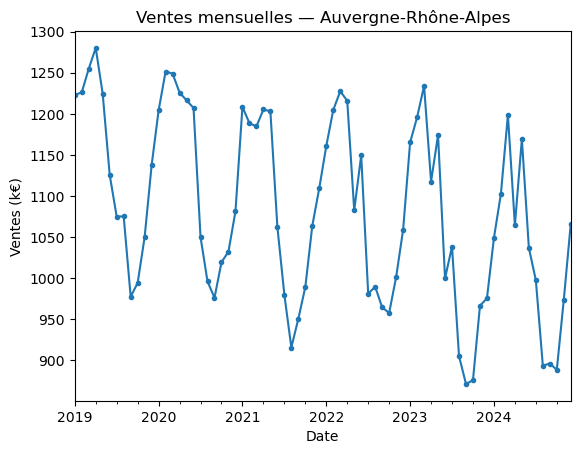

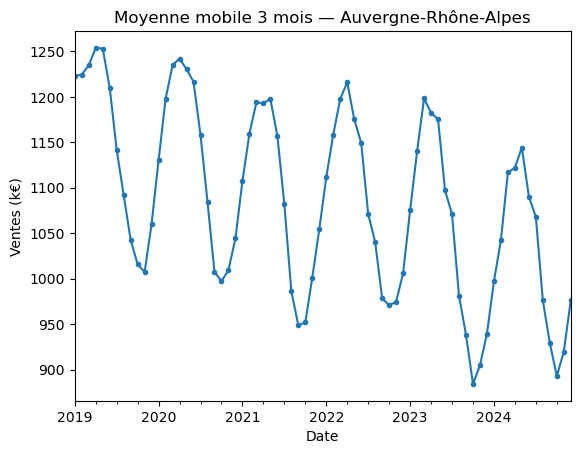

In [20]:
reg_demo = full_mm.reset_index().region.unique()[0]
serie = full_mm.reset_index().query('region == @reg_demo')[['date','ventes_k€','ventes_mm3']].set_index('date')
import matplotlib.pyplot as plt
plt.figure(); serie['ventes_k€'].plot(marker='.', title=f"Ventes mensuelles — {reg_demo}"); plt.xlabel('Date'); plt.ylabel('Ventes (k€)'); plt.show()
# figure() crée une nouvelle figure
# plot() trace la série avec des marqueurs en forme de point
# title() ajoute un titre au graphique
# xlabel() ajoute un label à l'axe des x
# ylabel() ajoute un label à l'axe des y
plt.figure(); serie['ventes_mm3'].plot(marker='.', title=f"Moyenne mobile 3 mois — {reg_demo}"); plt.xlabel('Date'); plt.ylabel('Ventes (k€)'); plt.show()

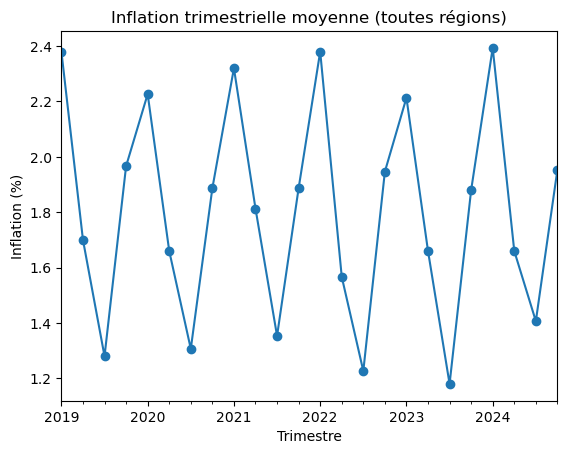

In [21]:
# Agréger l'inflation par période trimestrielle en utilisant l'index temporel de q
infl_tri = q.groupby(q.index.to_period('Q'))['inflation_pct_Q'].mean() 
# to_period() convertit des dates/horodatages (DatetimeIndex, Series de type datetime, ou colonne datetime) 
# en périodes calendaires (objet Period / PeriodIndex) selon une fréquence donnée (ex : 'D', 'M', 'Q', 'A', ...).
import matplotlib.pyplot as plt
plt.figure(); infl_tri.plot(marker='o', title='Inflation trimestrielle moyenne (toutes régions)'); plt.xlabel('Trimestre'); plt.ylabel('Inflation (%)'); plt.show()

## 6) Exports

In [22]:
out1 = os.path.join(OUT_DIR, "S4_ventes_inflation_chomage_mensuel.csv")
out2 = os.path.join(OUT_DIR, "S4_quarterly_kpis.csv")
full.reset_index().to_csv(out1, index=False, encoding='utf-8'); q.to_csv(out2, index=False, encoding='utf-8')
out1, out2

('outputs\\S4_ventes_inflation_chomage_mensuel.csv',
 'outputs\\S4_quarterly_kpis.csv')

---
## 7) Exercices
**E1. Corrélations par région (export attendu)**
Objectif : par région, calculer deux corrélations de Pearson :
  1. `corr_ventes_inflation` = corr(ventes_k€, taux_inflation),
  2. `corr_ventes_chomage` = corr(ventes_k€, chomage_pourcent).
Contraintes / étapes :
  - Travailler sur la table `full.reset_index()` (colonnes : `region`, `date`, `ventes_k€`, `taux_inflation`, `chomage_pourcent`).
  - Pour chaque région, éliminer les lignes où les deux colonnes testées sont NaN avant de calculer la corrélation (p.ex. dropna(subset=[x,y])).
  - Construire un DataFrame final avec les colonnes : `region`, `corr_ventes_inflation`, `corr_ventes_chomage`.
Export : sauvegarder ce DataFrame dans `outputs/S4_correlations.csv` (UTF-8, index=False).

**E2. Ventes réelles et YoY moyen par région (export attendu)**
Objectif : calculer les ventes corrigées de l'inflation et la moyenne du YoY par région :
Étapes :
  1. Créer la colonne `ventes_reelles = ventes_k€ / (1 + taux_inflation/100)`.
  2. Trier par `region, date` puis calculer le YoY en pourcentage sur 12 mois : `yoy_reel_% = ventes_reelles.pct_change(12)*100` (par région).
  3. Pour chaque région, calculer la moyenne du `yoy_reel_%` en ignorant les NaN (résultat `yoy_reel_moy_%`).
  4. Construire un DataFrame avec les colonnes : `region`, `yoy_reel_moy_%` et sauvegarder dans `outputs/S4_yoy_moyen_reel.csv` (UTF-8, index=False).
Conseils : gérer les périodes manquantes (min_periods) et filtrer les régions avec trop peu de données si nécessaire.

**E3 (bonus).** Comparez **MM6** et **MM12** sur 2 régions (2 graphiques).

In [ ]:
# E1


C:\Users\Jepssen\AppData\Local\Temp\ipykernel_17420\1297333024.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,region,corr_ventes_inflation,corr_ventes_chomage
0,Auvergne-Rhône-Alpes,0.483010,0.500967
1,Bretagne,0.558388,0.423867
2,Hauts-de-France,0.534155,0.395990
3,Occitanie,0.530621,0.548096
4,Île-de-France,0.428001,0.365180


In [ ]:
# E2


,region,yoy_reel_moy_%
3,Occitanie,-1.014652
0,Auvergne-Rhône-Alpes,-1.895332
2,Hauts-de-France,-2.015481
4,Île-de-France,-2.377807
1,Bretagne,-2.990930


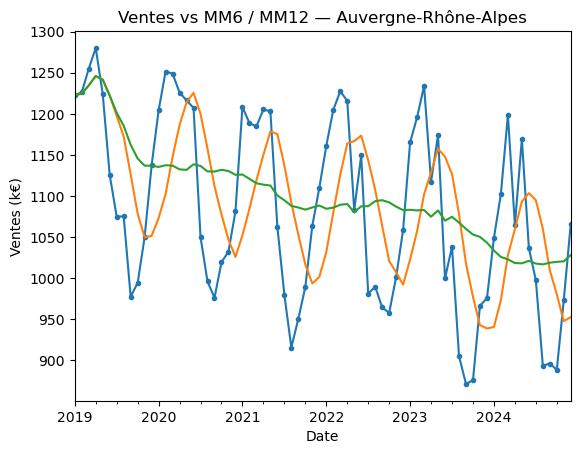

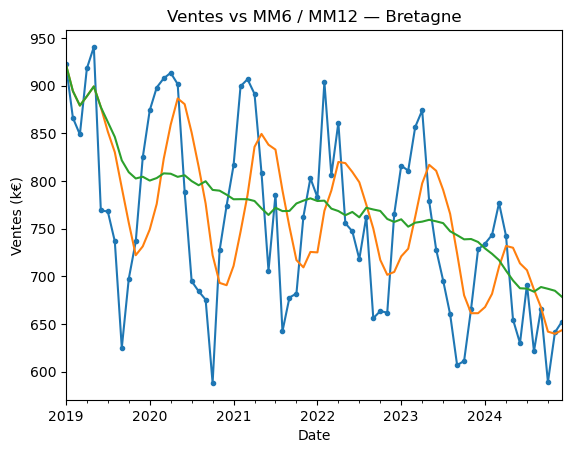

In [ ]:
# E3
